# Классификация отзывов с применением BERT

## Установка библиотек

Ставим библиотеку pytorch-transformers и импортим необходимые библиотеки

In [ ]:
!pip install pytorch-transformers

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, AdamW, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device('cpu'):
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla K80


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/data/IMDB Dataset.csv'

Mounted at /content/drive


## Загрузка данных


Ссылка на датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).
Датасет состоит из 50000 отзывов на английском языке, среди которых 25000 - положительные и 25000 - отрицательные

In [ ]:
texts = pd.read_csv(path)
texts.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
le = LabelEncoder()
texts['sentiment'] = le.fit_transform(texts['sentiment'])
texts['sentiment'].head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

In [ ]:
print(texts[texts['sentiment']==0].shape[0], texts[texts['sentiment']==1].shape[0])

25000 25000


Подготавливаем данные, чтобы их можно было подать в BERT для дообучения.  Добавляем метки "CLS" и "SEP" в начало и конец предложений.

In [ ]:
sentences = texts['review'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = texts['sentiment'].values

In [ ]:
print(len(sentences), len(labels), texts.shape[0])

50000 50000 50000


In [ ]:
print(sentences[111])

[CLS] I liked Boyle's performance, but that's about the only positive thing I can say. Everything was overdone to the point of absurdity. Most of the actors spoke like you would expect your 9-year-old nephew to speak if he were pretending to be a jaded, stone-hearted cop, or an ultra-evil villain. The raspy voice-overs seemed amateurish to me. I could go buy a cheap synthesizer and crank out better opening music. And what's with the whole 1984ish police torture stuff? It was totally superfluous and had nothing to do with the actual events of the story. Cox added a lot of things, in fact, that he apparently thought would be really cool, but had nothing to do with the story. That's a big disappointment because one of the things that makes Borges' stories so good is his minimalism -- they are tightly bound, with no superfluous details. This movie is just the opposite. I stopped watching after the scene where Lonnrot is questioning the guy from the Yidische Zaitung, or thereabouts. I waste

Делим данные на обучающую выборку и тестовую — то есть, некоторые данные откладываются и не используются в процессе дообучения, а затем на этой отложенной выборке померяется качество дообученной модели. Данные делятся в пропорции 70/30%. В обучающей выборке 35000 записей, а в тестовой 15000.

In [ ]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [ ]:
print(len(train_gt), len(test_gt))

35000 15000


## Inputs

Токенизатор "BertTokenizer" из pytorch-transformers для BERT превращает тексты в набор токенов, соответствующих тем, что встречались в словаре предобученной модели. 
"bert_base_uncased" означает, что используется токенизатор для модели BERT Base, содержащий внутри 12 self-attention модулей. "Uncased" означает, что все слова в словаре этого токенайзера написаны в нижнем регистре.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2924030.37B/s]


['[CLS]', 'one', 'of', 'the', 'better', 'teen', 'comedies', 'to', 'be', 'filmed', 'during', 'the', '80', "'", 's', ',', 'valley', 'girl', 'has', 'a', 'young', 'nicolas', 'cage', 'in', 'a', 'starring', 'role', '.', 'deborah', 'foreman', 'is', 'fun', 'as', 'the', 'object', 'of', 'cage', "'", 's', 'desire', '(', 'and', 'whatever', 'happened', 'to', 'her', '?', ')', '.', 'look', 'for', 'veteran', 'actors', 'colleen', 'camp', 'and', 'frederic', 'forrest', 'as', 'julie', "'", 's', 'hip', '##pie', 'parents', '-', 'they', "'", 're', 'quite', 'funny', '!', '[SEP]']


Так как длина отзывов может превышать 512, то их необходимо разбить

In [ ]:
MAX_LEN = 512  # В токенах, включая [CLS] и [SEP]
MIN_TAIL = 50  # В токенах

cut_tokenized_texts = []
cut_train_gt = []
for i, sentence in enumerate(tokenized_texts):
    if len(sentence) <= MAX_LEN:
        #  Копируем предложение и его метку без изменений
        cut_tokenized_texts.append(sentence)
        cut_train_gt.append(train_gt[i])
    else:
        # Длинный хвост разбиваем на несколько предложений
        sentence = sentence[1:-1]  # Удаляем метки [CLS] и [SEP]
        chunk_n = len(sentence) // (MAX_LEN - 2)
        if len(sentence) % (MAX_LEN - 2) >= MIN_TAIL: chunk_n += 1
        for n in range(chunk_n):
            chunk = sentence[(MAX_LEN - 2) * n : (MAX_LEN - 2) * (n + 1)]
            chunk.insert(0, '[CLS]')
            chunk.append('[SEP]')
            cut_tokenized_texts.append(chunk)
            cut_train_gt.append(train_gt[i])
            
tokenized_texts = cut_tokenized_texts
train_gt = cut_train_gt

Добавляем паддинг к предложениям. Для того, чтобы добавить паддинг предложениям, используем готовую функцию из keras под названием pad_sequences.

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=200,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Делим в пропорции 90% оставшихся данных — на обучение, 10% — на валидацию. Дальше мы превращаем наши данные в pytorch тензоры.

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

Формат лейблов - такой, чтобы поддерживать также возможность работы с задачами, где каждому объекту присваивается несколько классов. В нашем случае, у каждого предложения есть только одна метка — положительная или отрицательная эмоциональная окраска.

In [ ]:
train_labels

tensor([0, 0, 0,  ..., 1, 0, 0])

Создание итераторов с помощью DataLoader. Данные по батчам разбиваются произвольно с помощью RandomSampler. Размер батча - "16".

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16,
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16,
)

## Обучение модели

Берется "BertForSequenceClassification" с дополнительным полносвязным слоем размера ["hidden state", "количество классов"]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 440473133/440473133 [00:12<00:00, 36276036.73B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-6)

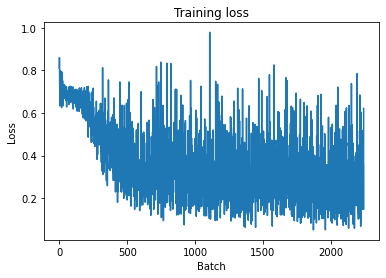

Loss на обучающей выборке: 0.36758


In [ ]:
# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

Сгладим график

In [ ]:
def smooth(scalars, weight):
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

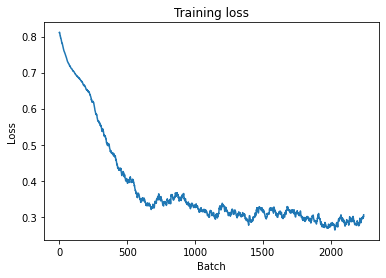

In [ ]:
#plt.figure(figsize=(10, 8), dpi=100)
plt.plot(smooth(train_loss_set, 0.98))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy().reshape(b_labels.shape[0],1)

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 87.81%


In [ ]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 87.81%


## Оценка качества на отложенной выборке

Повторяем предобработку для отложенной выборки

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

for i, text in enumerate(tokenized_texts):
    text = text[:512]
    text[-1] = '[SEP]'
    tokenized_texts[i] = text

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=300,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy().reshape(b_labels.shape[0],1)

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 91.05%


In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(np.asarray(test_labels) != np.asarray(test_preds)),
    len(test_labels)
))

Неправильных предсказаний: 1343/15000
